```
SOW-MKI95 Computer Graphics & Computer Vision Spring 2020
Dr. Umut Güçlü
Lab 13: Variational autoencoders
05-06-2020
```
```
Group number: 8
Chris Beem: s1044334
Nolan Cardozo: s1034065
Ajinkya Indulkar: s1034517
```

In [1]:
# import mxnet libraries
from mxnet import autograd, nd, gluon
from mxnet.gluon import nn

import time
import matplotlib.pyplot as plt
import mxnet as mx
import mxnet.ndarray as nd
import numpy as np
from numpy.matlib import repmat
from tqdm.notebook import tqdm

from scipy.special import ndtri
from scipy.stats import norm

%matplotlib inline

# set random seed (deterministic behaviour)
mx.random.seed(43)
np.random.seed(43)

Set Notebook Device

In [2]:
def gpu_exists():
    '''function to check GPU availability'''
    try:
        mx.nd.zeros((1,), ctx=mx.gpu(0))
    except:
        return False
    return True

data_ctx = mx.cpu()
if gpu_exists():
    print('Using GPU for model_ctx')
    model_ctx = mx.gpu(0)
else:
    print('Using CPU for model_ctx')
    model_ctx = mx.cpu()

Using CPU for model_ctx


In [3]:
# Global parameters
BATCH_SIZE = 100
N_HIDDEN   = 400
N_LATENT   = 2
N_LAYERS   = 1
N_OUTPUT   = 784
N_EPOCH    = 50
model_pfx  = 'vae_{}d{}l{}h.params'.format(N_LATENT, N_LAYERS, N_HIDDEN)

### Task 1 (10 points):

* Implement the decoder class for a variational autoencoder.

---o---

Recall that the decoder transforms latents (features) to observables (images). It corresponds to p(x | z) in the context of variational inference (and the slides), where x is observables and z is latents. Note that it should output the Gaussian parameters (mean and variance per pixel) of images rather than images themselves.

---o---

In [4]:
class Decoder(nn.HybridSequential):
    def __init__(self, activation = "relu", hiddens = 400, observables = 784, layers = 1, **kwargs): 
        super(Decoder, self).__init__(**kwargs)
        self.activation = activation
        self.hiddens = hiddens
        self.observables = observables
        self.layers = layers
        for i in range(self.layers):
            self.add(nn.Dense(self.hiddens, activation=self.activation))
        self.add(nn.Dense(self.observables*2, activation='sigmoid'))

### Task 2 (10 points):

* Implement the encoder class for a variational autoencoder.

---o---

Recall that the encoder transforms observables (images) to latents (features). It corresponds to q(z | x) in the context of variational inference (and the slides), where z is latents and x is observables. Note that it should output the Gaussian parameters (mean and variance per feature) of features rather than features themselves.

---o---

In [5]:
class Encoder(nn.HybridSequential):
    def __init__(self, activation = "relu", hiddens= 400, latents = 2, layers = 1, **kwargs): # Feel free to use different arguments
        super(Encoder, self).__init__(**kwargs)
        self.activation = activation
        self.hiddens = hiddens
        self.latents = latents
        self.layers = layers
        for i in range(self.layers):
            self.add(nn.Dense(self.hiddens, activation=self.activation))
        self.add(nn.Dense(self.latents*2, activation=None))

### Task:

* Implement the loss function class for a variational autoecoder.

---o---

The loss function takes the following arguments as input:

* x        : input images (mini batch)
* x_mean   : mean of the decoded images (output of the decoder)
* x_log_var: mean of the decoded images (output of the decoder)
* z_mean   : mean of the encoded features (output of the encoder)
* z_log_var: log variance of the encoded features (output of the encoder)

It gives the following evidence lower bound (ELBO) as ouput:

* $L = D_{KL}(q(z | x), p(z)) -  E_{z\sim q}[log p(x | z)]$

where

* The first term is the KL divergence between the approximate Gaussian posterior (q) and the standard Gaussian prior (p), which can be interpreted as a form of regularization.
* The second term is the Gaussian negative log likelihood, which is the term that fits the data and is very similar to the usual loss functions that are usded in deep learning.

---o---

In [6]:
class ELBOLoss:
    # Feel free to use different w which can be used as the weight of the different loss components
    def __init__(self, w = 1.0): 
        self.w = w

    def __call__(self, x, x_mean, x_log_var, z_mean, z_log_var):
        # compute Gaussian negative log likelihood
        logloss = nd.sum(0.5 * ((x_log_var + np.log(2 * np.pi)) + (x - x_mean) ** 2 * nd.exp(-x_log_var)), axis=1)
        # compute KL Divergence
        KL = nd.sum(0.5 * (z_mean ** 2 + nd.exp(z_log_var) - z_log_var - 1), axis=1)
        # compute ELBO
        loss = KL - (-logloss)
        return loss * self.w

### Task (5 points):

* Implement the variational autoencoder.

In [7]:
class VariationalAutoencoder(gluon.HybridBlock):
    '''Class for VAE Architecture'''
    def __init__(self,  activation = "relu", hiddens= 400, latents = 2, observables = 784, layers = 1, **kwargs): 
        super(VariationalAutoencoder, self).__init__()
        self.output = None
        self.mu = None
        with self.name_scope():
            self.decoder = Decoder(activation, hiddens, observables, layers, **kwargs)
            self.encoder = Encoder(activation, hiddens, latents, layers, **kwargs)

    def hybrid_forward(self, F, x):
        '''function for forward pass of the network'''
        # feed through encoder
        h = self.encoder(x) # [BATCHSIZE x 4] encoder output
        mu_lv = F.split(h, axis=1, num_outputs=2)
        z_mean = mu_lv[0] # [BATCHSIZE x 2] encoder output mean
        z_log_var = mu_lv[1] # [BATCHSIZE x 2] encoder output log variance
        
        # store encoder output
        self.mu = z_mean
        
        # draw samples from Normal Distribution
        eps = F.random_normal(loc=0, scale=1, shape=(BATCH_SIZE, N_LATENT), ctx=model_ctx)
        
        # compute latent variable
        z = z_mean + F.exp(0.5*z_log_var)*eps
        
        # feed through decoder
        y = self.decoder(z)
        y_split = F.split(y, axis=1, num_outputs=2)
        x_mean = y_split[0] # [BATCHSIZE x 2] encoder output mean
        x_log_var = y_split[1] # [BATCHSIZE x 2] encoder output log variance
        
        # store decoder output
        self.output = x_mean

        return x_mean, x_log_var, z_mean, z_log_var

### Task (25 points):

* Train the variational autoencoder on the Mnist dataset. You can refer to the previous assignment to implement your training loop.

#### Load MNIST Data

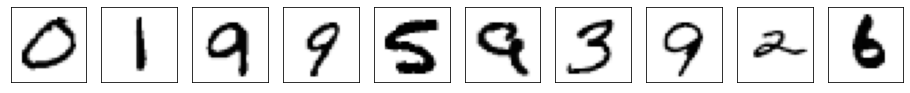

In [8]:
mnist = mx.test_utils.get_mnist()

n_samples = 10
idx = np.random.choice(len(mnist['train_data']), n_samples)
_, axarr = plt.subplots(1, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[i].imshow(mnist['train_data'][j][0], cmap='Greys')
    axarr[i].get_xaxis().set_ticks([])
    axarr[i].get_yaxis().set_ticks([])
plt.show()

In [9]:
# inspect dataset
print("Train - Number of samples: {} | shape of samples: {} | shape of labels: {}".format(mnist['train_data'].shape[0],
                                                                                         mnist['train_data'].shape,
                                                                                         mnist['train_label'].shape))
print("Test - Number of samples: {} | shape of samples: {} | shape of labels: {}".format(mnist['test_data'].shape[0],
                                                                                         mnist['test_data'].shape,
                                                                                         mnist['test_label'].shape))

Train - Number of samples: 60000 | shape of samples: (60000, 1, 28, 28) | shape of labels: (60000,)
Test - Number of samples: 10000 | shape of samples: (10000, 1, 28, 28) | shape of labels: (10000,)


In [10]:
# reshape train and test sets
train_data = np.reshape(mnist['train_data'],(-1,28*28))
test_data = np.reshape(mnist['test_data'],(-1,28*28))

# define data loaders
n_batches = train_data.shape[0]/BATCH_SIZE
train = mx.io.NDArrayIter(data={'data': train_data}, label={'label': mnist['train_label']}, 
                               batch_size = BATCH_SIZE)
test  = mx.io.NDArrayIter(data={'data': test_data}, label={'label': mnist['test_label']}, 
                              batch_size = BATCH_SIZE)

#### Train Model

In [11]:
# define model
net = VariationalAutoencoder(hiddens=N_HIDDEN, latents=N_LATENT, observables=N_OUTPUT, layers=N_LAYERS)
# initialize model
net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)
net.hybridize()
# define optimizer and loss criterion
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .001})
criterion = ELBOLoss()

In [12]:
print_period = N_EPOCH // 10
start = time.time()
training_loss = []
validation_loss = []

# train over N_EPOCH
for epoch in tqdm(range(N_EPOCH), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0
    
    # reset data loaders
    train.reset()
    test.reset()
    
    # iterate over train data and update model
    n_batch_train = 0
    for batch in train:
        n_batch_train +=1
        # fetch data
        x = batch.data[0].as_in_context(model_ctx)
        with autograd.record():
            # feed-forward function
            x_mean, x_log_var, z_mean, z_log_var = net(x) 
            # compute loss
            loss = criterion(x, x_mean, x_log_var, z_mean, z_log_var) 
        # backprop
        loss.backward() 
        # optimizer step
        trainer.step(x.shape[0]) 
        # save loss
        epoch_loss += nd.mean(loss).asscalar()
    
    # iterate over test data and compute loss
    n_batch_val = 0
    for batch in test:
        n_batch_val +=1
        x = batch.data[0].as_in_context(model_ctx)
        x_mean, x_log_var, z_mean, z_log_var = net(x) 
        # compute loss
        loss = criterion(x, x_mean, x_log_var, z_mean, z_log_var)
        # save loss
        epoch_val_loss += nd.mean(loss).asscalar()

    # normalize losses
    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val
    
    # save losses
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    # print training logs
    if epoch % max(print_period,1) == 0:
        tqdm.write('Epoch{}, Training loss {:.2f}, Validation loss {:.2f}'.format(epoch, epoch_loss, epoch_val_loss))

end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

Epoch0, Training loss 755.45, Validation loss 745.36
Epoch5, Training loss 743.07, Validation loss 743.05
Epoch10, Training loss 742.54, Validation loss 742.56
Epoch15, Training loss 742.24, Validation loss 742.28
Epoch20, Training loss 742.07, Validation loss 742.11
Epoch25, Training loss 741.87, Validation loss 741.91
Epoch30, Training loss 741.72, Validation loss 741.81
Epoch35, Training loss 741.59, Validation loss 741.70
Epoch40, Training loss 741.47, Validation loss 741.62
Epoch45, Training loss 741.37, Validation loss 741.49

Time elapsed: 948.40s


In [13]:
# save model
net.save_parameters(model_pfx)

#### Plot Training

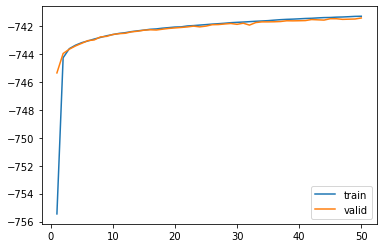

In [14]:
batch_x = np.linspace(1, N_EPOCH, len(training_loss))
plt.figure()
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])
plt.show()

### Task (50 points):
* Evaluate the reconstruction quality of the variational autoencoder: Draw some Mnist like images, encode them, decode them, visualize them and briefly explain the results.
 * Repeat the task with drawings of something else (e.g., a face).
* Evaluate the sampling quality of the variational autoencoder: Sample some random features from the prior, decode them, visualize them and briefly explain the results.
 * Repeat the task with features on a regular grid.
* Evaluate the latent quality of the variational autoencoder: Scatter plot features of images, color code their labels.

In [15]:
# load model
net2 = VariationalAutoencoder(hiddens=N_HIDDEN, latents=N_LATENT, observables=N_OUTPUT, layers=N_LAYERS)
net2.load_parameters(model_pfx, ctx=model_ctx)

#### Visualizing Reconstruction Quality

In [16]:
# reset test data loader
test.reset()
# fetch first batch from data loader
test_batch = test.next()
# pass test batch input through the network
x_mean, x_log_var, z_mean, z_log_var = net2(test_batch.data[0].as_in_context(model_ctx))
# fetch output
result = net2.output.asnumpy() # CHANGE THIS
original = test_batch.data[0].asnumpy()

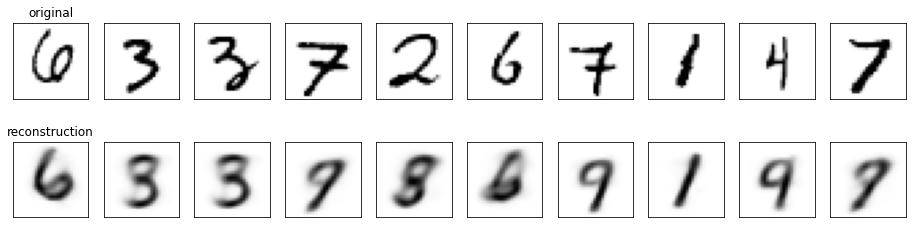

In [17]:
n_samples = 10
idx = np.random.choice(BATCH_SIZE, n_samples)
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[0,i].imshow(original[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

Load New Dataset and observe reconstruction

#### Sample latent space and generate images
Random sampling

In [18]:
n_samples = 20
zsamples = nd.array(np.random.randn(n_samples*n_samples, N_LATENT))
# images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()
images = nd.split(net2.decoder(zsamples.as_in_context(model_ctx)), axis=1, num_outputs=2)[0].asnumpy()

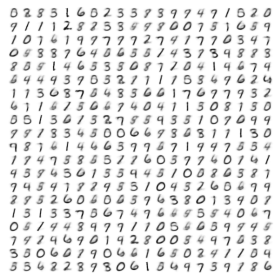

In [19]:
canvas = np.empty((28*n_samples, 28*n_samples))
for i, img in enumerate(images):
    x = i // n_samples
    y = i % n_samples
    canvas[(n_samples-y-1)*28:(n_samples-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
plt.figure(figsize=(4, 4))
plt.imshow(canvas, origin="upper", cmap="Greys")
plt.axis('off')
plt.tight_layout()
plt.show()

Grid scan 2D latent space

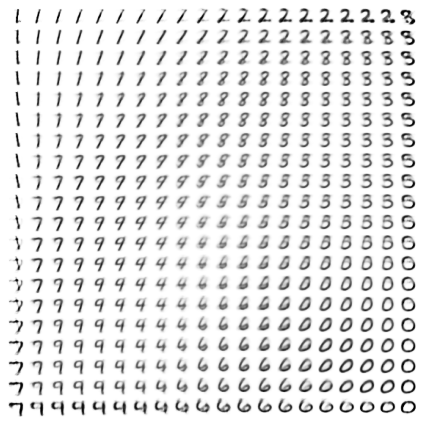

In [20]:
# plot latent space
if N_LATENT==2:
    n_pts = 20

    idx = np.arange(0, n_pts)

    x = np.linspace(norm.cdf(-3), norm.cdf(3),n_pts)
    x = ndtri(x)

    x_grid = np.array(np.meshgrid(*[i for i in repmat(x,N_LATENT,1)]))
    id_grid = np.array(np.meshgrid(*[i for i in repmat(idx,N_LATENT,1)]))

    zsamples = nd.array(x_grid.reshape((N_LATENT, -1)).transpose())
    zsamples_id = id_grid.reshape((N_LATENT, -1)).transpose()

#     images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()
    images = nd.split(net2.decoder(zsamples.as_in_context(model_ctx)), axis=1, num_outputs=2)[0].asnumpy()

    # plot
    canvas = np.empty((28*n_pts, 28*n_pts))
    for i, img in enumerate(images):
        x, y = zsamples_id[i]
        canvas[(n_pts-y-1)*28:(n_pts-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas, origin="upper", cmap="Greys")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Visualizing latent space (when it is 2D)

In [21]:
n_batches = 10
counter = 0
results = []
labels = []
for batch in test:
    x_mean, x_log_var, z_mean, z_log_var = net2(batch.data[0].as_in_context(model_ctx))
    results.append(net2.mu.asnumpy()) # CHANGE THIS
    labels.append(batch.label[0].asnumpy())
    counter +=1
    if counter >= n_batches:
        break

# transform lists
result = np.vstack(results)
labels = np.hstack(labels)

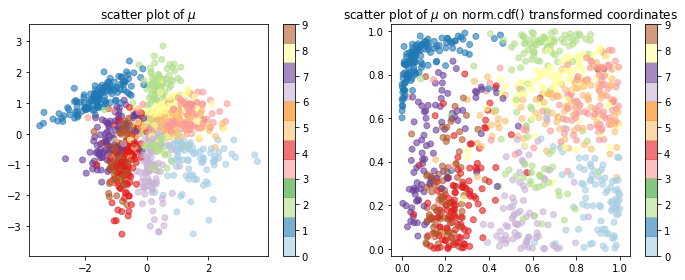

In [22]:
# plot latent space
if result.shape[1]==2:
    fig, axarr = plt.subplots(1,2, figsize=(10,4))
    im=axarr[0].scatter(result[:, 0], result[:, 1], c=labels, alpha=0.6, cmap='Paired')
    axarr[0].set_title(r'scatter plot of $\mu$')
    axarr[0].axis('equal')
    fig.colorbar(im, ax=axarr[0])

    im=axarr[1].scatter(norm.cdf(result[:, 0]), norm.cdf(result[:, 1]), c=labels, alpha=0.6, cmap='Paired')
    axarr[1].set_title(r'scatter plot of $\mu$ on norm.cdf() transformed coordinates')
    axarr[1].axis('equal')
    fig.colorbar(im, ax=axarr[1])
    plt.tight_layout()
    plt.show()